<a href="https://colab.research.google.com/github/albertklorer/spam-classification/blob/master/spam_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Spam classifier built using a deep neural network. The dataset used can be found [here](https://www.kaggle.com/uciml/sms-spam-collection-dataset) and must be uploaded to files before the notebook is run. 

In [436]:
!pip install glove_python
!pip install wordcloud

Import dependencies

In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import re
import nltk
import wordcloud
import zipfile
import glove
from sklearn.model_selection import train_test_split

Load data from csv

In [438]:
data = pd.read_csv('spam.csv', encoding='latin-1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


Rename columns, drop extraneous feature, and replace 'ham' and 'spam' labels with 0 and 1.

In [439]:
data = data.rename(columns={'v1': 'Label', 'v2': 'Text'})
data = data[['Label', 'Text']]
data['Label'] = data['Label'].replace('ham', 0)
data['Label'] = data['Label'].replace('spam', 1)
data.head()

,Label,Text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Visualize distribution of labels

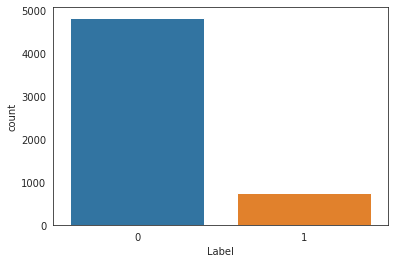

In [440]:
sns.set_style('white')
sns.countplot(x='Label', data=data)

Since the dataset is fairly imbalenced it is prudent to penalize misclassifcation of spam emails more severely. Lets now clean the text by removing non-alphabetic characters.

In [441]:
data['Text'] = data['Text'].str.lower()
data['Text'].replace(r'[^a-z ]', '', regex=True, inplace=True)
data.head()

,Label,Text
0,0,go until jurong point crazy available only in ...
1,0,ok lar joking wif u oni
2,1,free entry in a wkly comp to win fa cup final...
3,0,u dun say so early hor u c already then say
4,0,nah i dont think he goes to usf he lives aroun...


Remove stop words from text and split into a list of words

In [442]:
nltk.download('stopwords')
data['Text'] = data['Text'].str.split()
data['Text'].apply(lambda x: [item for item in x if item not in nltk.corpus.stopwords.words('english')])
data['Text'] = np.array(data['Text'])
data.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Label,Text
0,0,"[go, until, jurong, point, crazy, available, o..."
1,0,"[ok, lar, joking, wif, u, oni]"
2,1,"[free, entry, in, a, wkly, comp, to, win, fa, ..."
3,0,"[u, dun, say, so, early, hor, u, c, already, t..."
4,0,"[nah, i, dont, think, he, goes, to, usf, he, l..."


Generate wordcloud for spam tweets

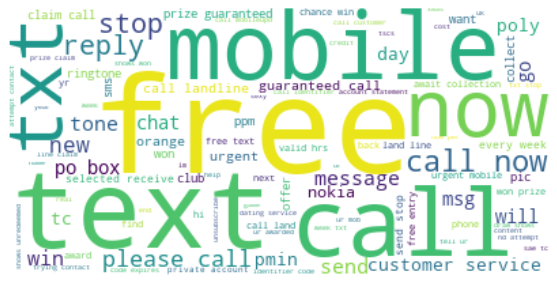

In [443]:
text = ''
for index, row in data.iterrows():
  if row['Label'] == 1:
    for word in row['Text']:
      text = text + word + ' '

cloud = wordcloud.WordCloud(max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Generate wordcloud for ham tweets

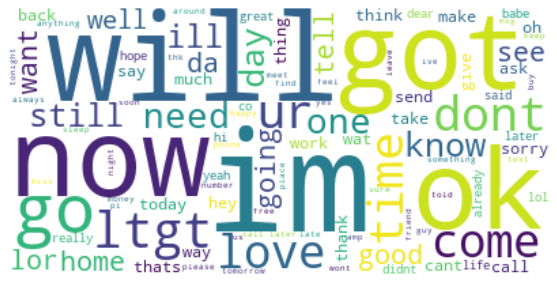

In [444]:
text = ''
for index, row in data.iterrows():
  if row['Label'] == 0:
    for word in row['Text']:
      text = text + word + ' '

cloud = wordcloud.WordCloud(max_words=100, background_color="white").generate(text)
plt.figure(figsize=(10,5))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

It is clear from these word clouds that there is a notable difference between the vocabulary used in ham and spam messages. Lets now focus on vectorizing our text inputs so that they can interface with our model. 

In [445]:
# apply word vectorizations with glove
glove_corpus = glove.Corpus()
glove_corpus.fit(data['Text'].values, window=10)

word_embedding = glove.Glove(no_components=25, learning_rate=0.05)
word_embedding.fit(glove_corpus.matrix, epochs=20, no_threads=4)
word_embedding.add_dictionary(glove_corpus.dictionary)

for i, row in data.iterrows():
  for j, word in enumerate(row['Text']):
    data.iloc[data.index[i], 1][j] = np.array(word_embedding.word_vectors[word_embedding.dictionary.get(word)])

data.head()

,Label,Text
0,0,"[[0.438613144039525, 0.2532595125435295, 0.207..."
1,0,"[[0.3165609055097239, 0.12452466670320131, -0...."
2,1,"[[0.1904370354354676, 0.31808738128096437, 0.4..."
3,0,"[[0.5426732354601356, 0.09734627119667535, -0...."
4,0,"[[-0.06907631927189811, -0.055775577039374566,..."


Split into x and y training sets and flatten vectors.

In [446]:
# split data
x_train, x_test, y_train, y_test = train_test_split(data['Text'].to_numpy(), data['Label'].to_numpy())

# flatten x data with a limit of 50 words per message
for i in range(len(x_train)):
  if len(x_train[i]) == 50:
    x_train[i] = np.array(x_train[i]).flatten()
  elif len(x_train[i]) > 50:
    x_train[i] = np.array(x_train[i]).flatten()[0:25 * 50]
  else:
    x_train[i] = np.array(x_train[i]).flatten()
    x_train[i] = np.append(x_train[i], np.zeros((25 * 50) - len(x_train[i])))

for i in range(len(x_test)):
  if len(x_test[i]) == 50:
    x_test[i] = np.array(x_test[i]).flatten()
  elif len(x_test[i]) > 50:
    x_test[i] = np.array(x_test[i]).flatten()[0:25 * 50]
  else:
    x_test[i] = np.array(x_test[i]).flatten()
    x_test[i] = np.append(x_test[i], np.zeros((25 * 50) - len(x_test[i])))

# convert from list of arrays to 2d array
x_train = np.stack(x_train, axis=0)
x_test = np.stack(x_test, axis=0)
y_train = np.stack(y_train, axis=0)
y_test = np.stack(y_test, axis=0)

x_train.shape

(4179, 1250)

Build keras DNN model

In [447]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2048, input_shape=(25*50,)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(2048),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(512),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(1)
])

model.build()
model.summary()

model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
  optimizer=tf.keras.optimizers.Adam(1e-4),
  metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_106 (Dense)            (None, 2048)              2562048   
_________________________________________________________________
dropout_83 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_107 (Dense)            (None, 2048)              4196352   
_________________________________________________________________
dropout_84 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_108 (Dense)            (None, 512)               1049088   
_________________________________________________________________
dropout_85 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_109 (Dense)            (None, 1)               

Train model and evaluate accuracy

In [448]:
with tf.device('/device:GPU:0'):
  history = model.fit(x_train, y_train, epochs=50, verbose=0)

model.evaluate(x_test, y_test)

44/44 [==============================] - 0s 2ms/step - loss: 0.4011 - accuracy: 0.9476


[0.40106379985809326, 0.9475951194763184]

44/44 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.9627


[0.1894141137599945, 0.9626705050468445]

Visualize training accuracy

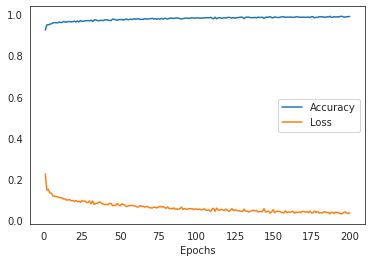

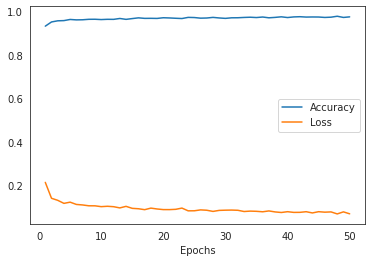

In [449]:
accuracy = history.history['accuracy']
loss = history.history['loss']
epochs = range(1, len(accuracy)+1)

plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, loss, label='Loss')
plt.xlabel('Epochs')
plt.legend()

plt.show()